# Tensorflow Multivariate Probability


#### Reference
[Gentle introduction to Tensorflow Probability](https://towardsdatascience.com/gentle-introduction-to-tensorflow-probability-distribution-objects-1bb6165abee1/)

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('ignore')     #switch betweeb 'default' and 'ignore'
import traceback

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True


## Instantiate Classes

In [3]:
import os
import sys
import numpy as np
from pyspark.sql import functions as F
import tensorflow_probability as tfp
import tensorflow as tf

proj_dir = os.path.abspath(os.pardir)
sys.path.insert(1,proj_dir.split('mining/')[0])
# from rezaware.modules.etl.loader import sparkRDBM as db
from rezaware.modules.etl.loader import sparkFile as file
# from rezaware.modules.etl.loader import __propAttr__ as attr

''' restart initiate classes '''
if debug:
    import importlib
    # db = importlib.reload(db)
    file=importlib.reload(file)
    # attr=importlib.reload(attr)

__desc__ = "read and write BigQuery dataset for hypothese testing"
# clsSDB = db.dataWorkLoads(
#     desc=__desc__,
#     db_type = 'bigquery',
#     db_driver=None,
#     db_hostIP=None,
#     db_port = None,
#     db_name = None,
#     db_schema='combined_data_facebook_ads',
#     spark_partitions=None,
#     spark_format = 'bigquery',
#     spark_save_mode=None,
#     # spark_jar_dir = _jar,
# )
clsFile = file.dataWorkLoads(
    desc = "optimizing action_type budgets for an ad",
    store_mode='local-fs',
    store_root=proj_dir.split('mining/')[0],
    jar_dir=None,
)
# if clsSDB.session:
#     clsSDB._session.stop
print("\n%s class initialization and load complete!" % __desc__)

All functional SPARKFILE-libraries in LOADER-package of ETL-module imported successfully!
__propAttr__ Class initialization complete
sparkFile Class initialization complete

read and write BigQuery dataset for hypothese testing class initialization and load complete!


## Load data

In [4]:
options = {
    "inferSchema":True,
    "header":True,
    "delimiter":",",
    "pathGlobFilter":'*.csv',
    "recursiveFileLookup":True,
}

sdf=clsFile.read_files_to_dtype(
    as_type = "SPARK",      # optional - define the data type to return
    folder_path="mining/data/budget/",  # optional - relative path, w.r.t. self.storeRoot
        file_name="complete-60-accounts.csv",  # optional - name of the file to read
        file_type=None,  # optional - read all the files of same type
        **options,
)
print("Loaded %d rows" % sdf.count())
sdf.printSchema()

25/02/16 09:31:42 WARN Utils: Your hostname, Waidy-Think-Three resolves to a loopback address: 127.0.1.1; using 192.168.2.82 instead (on interface enp0s25)
25/02/16 09:31:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/02/16 09:31:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/16 09:31:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
                                                                                

Loaded 61513 rows
root
 |-- account_id: long (nullable = true)
 |-- ad_id: long (nullable = true)
 |-- adset_id: long (nullable = true)
 |-- campaign_id: long (nullable = true)
 |-- updated_time: date (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- frequency: double (nullable = true)
 |-- reach: integer (nullable = true)
 |-- CTR: double (nullable = true)
 |-- CPC: double (nullable = true)
 |-- CPM: double (nullable = true)
 |-- ROAS: double (nullable = true)
 |-- social_spend: double (nullable = true)
 |-- spend: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- auction_bid: integer (nullable = true)
 |-- goal: string (nullable = true)
 |-- purchase_value: double (nullable = true)
 |-- account_currency: string (nullable = true)
 |-- purchase: double (nullable = true)
 |-- fb_pixel_view_value: double (nullable = true)
 |-- fb_pixel_purchase_value: double (nullable = true)
 |-- fb_pixel_add_to_cart_value: double (nullable = true)
 |-- mobile_app_purc

## Filter data into Inputs and Outputs


In [28]:
### REDUNDANT ###
from pyspark.sql import functions as F

filt_sdf = sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna()
print(filt_sdf.count())
mean_stddev_sdf = filt_sdf.agg(F.mean('spend').alias('spend_mean'), F.mean('CTR').alias('CTR_mean'), 
                        F.mean('CPC').alias('CPC_mean'), F.mean('CPM').alias('CPM_mean'), 
                        F.mean('ROAS').alias('ROAS_mean'),
                        F.stddev('spend').alias('spend_stddev'), F.stddev('CTR').alias('CTR_stddev'), 
                        F.stddev('CPC').alias('CPC_stddev'), F.stddev('CPM').alias('CPM_stddev'),
                        F.mean('ROAS').alias('ROAS_stddev'))
_lb = mean_stddev_sdf.select(F.col('spend_mean')).first()[0] + \
        2*mean_stddev_sdf.select(F.col('spend_stddev')).first()[0]
filt_sdf = filt_sdf.select('*').where(F.col('spend') <= _lb)
                   
print(filt_sdf.count())

26193
25554


In [15]:
    # 'spend','omni_view_content_value', 'omni_add_to_cart_value',
    # 'omni_initiated_checkout_value', 'omni_purchase_value').dropna().collect())

_data_df= sdf.select('spend','CTR', 'CPC', 'CPM', 'ROAS').dropna().toPandas()
print(_data_df.shape)
_data_df = _data_df[_data_df['spend']<=\
                    _data_df['spend'].mean()+2*_data_df['spend'].std()]
_data_df = _data_df[_data_df['CTR']<=\
                    _data_df['CTR'].mean()+2*_data_df['CTR'].std()]
_data_df = _data_df[_data_df['CPC']<=\
                    _data_df['CPC'].mean()+2*_data_df['CPC'].std()]
_data_df = _data_df[_data_df['ROAS']<=\
                    _data_df['ROAS'].mean()+2*_data_df['ROAS'].std()]
_data_df = _data_df[_data_df['CPM']<=\
                    _data_df['CPM'].mean()+2*_data_df['CPM'].std()]
# _data_df = _data_df[_data_df['spend']<=4000]

# _data_df = _data_df.sample(n=1000)

print("data shape:", _data_df.shape)
print("data quartile  :\n", _data_df.describe())

(26193, 5)
data shape: (21771, 5)
data quartile  :
               spend           CTR           CPC           CPM          ROAS
count  21771.000000  21771.000000  21771.000000  21771.000000  21771.000000
mean     653.172401      3.125367      4.070958     83.640293      4.484789
std      867.888233      2.342454      4.019480     61.742344     19.268487
min        0.060000      0.000000      0.000000      2.310524      0.000332
25%       57.765000      1.374857      1.184179     35.298006      0.650808
50%      310.560000      2.338685      2.478642     63.228397      1.412899
75%      869.595000      4.281987      5.667179    117.630144      3.164864
max     4371.290000     11.179441     19.852045    268.761782    571.764706


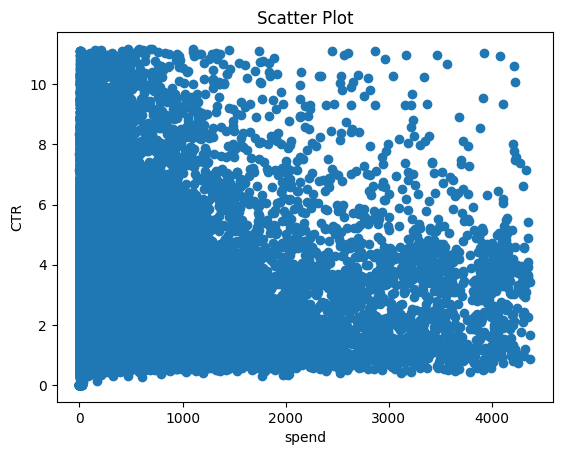

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(_data_df['spend'],_data_df['CTR'])
plt.title("Scatter Plot")
plt.xlabel("spend")
plt.ylabel("CTR")
plt.show()

## Define the model

* [Probabilistic Modeling with TensorFlow Probability](https://www.scaler.com/topics/tensorflow/tensorflow-probability/)
* [Tensorflow probability examples](https://github.com/tensorflow/probability/tree/main/tensorflow_probability/examples/jupyter_notebooks)

## Split the train & test data

In [32]:
# Compile and train the standard neural network
_pred_cols = ['CTR','CPC', 'CPM', 'ROAS']
_label_col = ['spend']
X = np.array(_data_df[_pred_cols])
y = np.array(_data_df[_label_col])             
print("X: ",X.shape,"y: ", y.shape)

X:  (1000, 4) y:  (1000, 1)


In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print("X_train: ",X_train.shape, "y_train: ", y_train.shape,
      "\nX_test: ", X_test.shape, "y_test: ", y_test.shape)

X_train:  (800, 4) y_train:  (800, 1) 
X_test:  (200, 4) y_test:  (200, 1)


## Define probabilisti priors model parameters

In [21]:
# Define variables with priors
w = tfp.util.TransformedVariable(
    initial_value=tf.random.normal([]),
    bijector=tfp.bijectors.Exp(),
    name='w'
)
b = tfp.util.TransformedVariable(
    initial_value=tf.random.normal([]),
    bijector=tfp.bijectors.Identity(),
    name='b'
)
print(w.name, w.numpy(), b.name, b.numpy())

w 0.57595384 b -0.12800595


## Define the Probabilistic Model

In [22]:
# Likelihood: Normal distribution
likelihood = tfp.distributions.Normal(loc=X * w + b, scale=1.0)

# Prior: Normal distribution
prior = tfp.distributions.Normal(loc=0.0, scale=1.0)


## Define Joint Log-Probability Function
This function is pivotal in Bayesian inference, aiding the estimation of posterior distributions for the parameters.

In [23]:
def joint_log_prob(w, b):
    return tf.reduce_sum(likelihood.log_prob(y)) + prior.log_prob(w) + prior.log_prob(b)


## Perform Inference
It generates num_samples samples after a num_burnin_steps burn-in period using the defined HMC kernel with specified leapfrog steps and step size. The resulting samples provide insights into the parameter distributions, crucial for understanding uncertainty in Bayesian modelling.

In [24]:
# Run Hamiltonian Monte Carlo
num_samples = 1000
num_burnin_steps = 500
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=joint_log_prob,
    num_leapfrog_steps=10,
    step_size=0.1
)
samples, _ = tfp.mcmc.sample_chain(
    num_results=num_samples,
    num_burnin_steps=num_burnin_steps,
    current_state=[w, b],
    kernel=hmc
    )

## Analyze Results:
Analyze the posterior samples to make predictions and infer uncertainty.

In [25]:
# Compute posterior means and standard deviations
w_posterior_mean = tf.math.reduce_mean(samples[0])
print('w posterior mean',w_posterior_mean.numpy())
b_posterior_mean = tf.math.reduce_mean(samples[1])
print('b posterior mean',b_posterior_mean.numpy())
w_posterior_stddev = tf.math.reduce_std(samples[0])
print('w posterior stdv',w_posterior_stddev.numpy())
b_posterior_stddev = tf.math.reduce_std(samples[1])
print('b posterior stdv',b_posterior_stddev.numpy())

# Make predictions
X_new = tf.constant([5.0])
y_pred = X_new * w_posterior_mean + b_posterior_mean
print('Predicted y',y_pred.numpy())

w posterior mean -0.8213489
b posterior mean -0.34411883
w posterior stdv 2.3247328
b posterior stdv 2.0848193
Predicted y [-4.450864]


In [107]:
import tensorflow_probability as tfp
import tensorflow as tf

# tfd = tfp.distributions

# Create a normal distribution with mean 0 and standard deviation 1
normal_dist = tfp.distributions.MultivariateNormalDiag(
    loc=list(np.mean(_inputs,axis=0)), scale_diag=list(np.std(_inputs,axis=0)))

# Sample 10 values from the distribution
samples = normal_dist.sample(1000)
print(samples)

pdf = normal_dist.prob([111.85, 3.141218, 0.972609, 30.551762, 2.24693786])
print(pdf)

tf.Tensor(
[[ 2.49643744e+03 -7.88446263e-01  1.71886128e+01  2.15684666e+02
  -4.87337512e+02]
 [ 2.01140934e+03 -1.95461483e+00  1.84851381e+00  2.43528923e+01
   2.91290725e+02]
 [ 1.63743996e+03  4.74646288e+00  4.12711029e+00  1.60024312e+02
  -9.49096400e+01]
 ...
 [ 5.76136509e+02  6.74416321e-01  3.23089529e+00  1.09023232e+01
  -4.26150400e+02]
 [-1.20320048e+03  3.98268872e+00  1.91826767e-01  3.30172761e+02
   2.21872526e+02]
 [ 2.47465358e+03  4.31270382e+00 -7.15948113e-01 -1.10345032e+02
  -1.75742185e+02]], shape=(1000, 5), dtype=float64)
tf.Tensor(4.215444140563353e-12, shape=(), dtype=float64)


In [109]:
# Create a bijector (example: Sigmoid)
sigmoid_bijector = tfp.bijectors.Sigmoid()

# Apply the bijector to a sample
x = tf.constant([-1.0, 0.0, 1.0])
y = sigmoid_bijector.forward(x)
print(x,y)

tf.Tensor([-1.  0.  1.], shape=(3,), dtype=float32) tf.Tensor([0.26894143 0.5        0.7310586 ], shape=(3,), dtype=float32)
